In [22]:
# Install AI Fairness 360
!pip install aif360


In [23]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [24]:
# 1. Fetch COMPAS dataset online from ProPublica
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [25]:
# 2. Select relevant columns for fairness analysis
# We use race as protected attribute, recidivism (two_year_recid) as label
df = df[['age', 'sex', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]
df

,age,sex,race,priors_count,c_charge_degree,two_year_recid
0,69,Male,Other,0,F,0
1,34,Male,African-American,0,F,1
2,24,Male,African-American,4,F,1
3,23,Male,African-American,1,F,0
4,43,Male,Other,2,F,0
...,...,...,...,...,...,...
7209,23,Male,African-American,0,F,0
7210,23,Male,African-American,0,F,0
7211,57,Male,Other,0,F,0
7212,33,Female,African-American,3,M,0


In [26]:
# Convert categorical columns to numeric
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['c_charge_degree'] = df['c_charge_degree'].map({'F': 1, 'M': 0})
df['race'] = df['race'].apply(lambda x: 1 if x == 'African-American' else 0)  # 1 = Black, 0 = White/Other

/tmp/ipython-input-82444512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
/tmp/ipython-input-82444512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_charge_degree'] = df['c_charge_degree'].map({'F': 1, 'M': 0})
/tmp/ipython-input-82444512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [27]:
# Define protected and privileged groups
protected_attr = 'race'
privileged_groups = [{protected_attr: 0}]   # White/Other
unprivileged_groups = [{protected_attr: 1}] # Black

In [28]:
# Create BinaryLabelDataset for AI Fairness 360
dataset = BinaryLabelDataset(df=df,
                             label_names=['two_year_recid'],
                             protected_attribute_names=[protected_attr])

dataset

               instance weights features                           \
                                              protected attribute   
                                     age  sex                race   
instance names                                                      
0                           1.0     69.0  1.0                 0.0   
1                           1.0     34.0  1.0                 1.0   
2                           1.0     24.0  1.0                 1.0   
3                           1.0     23.0  1.0                 1.0   
4                           1.0     43.0  1.0                 0.0   
...                         ...      ...  ...                 ...   
7209                        1.0     23.0  1.0                 1.0   
7210                        1.0     23.0  1.0                 1.0   
7211                        1.0     57.0  1.0                 0.0   
7212                        1.0     33.0  0.0                 1.0   
7213                        1.0   

In [29]:
# 3. Initial bias metrics
metric = BinaryLabelDatasetMetric(dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

print("Disparate Impact:", metric.disparate_impact())
print("Mean Difference:", metric.mean_difference())

Disparate Impact: 1.3403314894981562
Mean Difference: 0.13059906504335156


In [30]:
# 4. Train a classifier
X = df[['age', 'sex', 'priors_count', 'c_charge_degree']].values
y = df['two_year_recid'].values

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = LogisticRegression(solver='liblinear')
clf.fit(X_scaled, y)
y_pred = clf.predict(X_scaled)

# Convert predictions into AIF360 dataset
dataset_pred = dataset.copy()
dataset_pred.labels = y_pred



In [32]:
# Classification metrics
class_metric = ClassificationMetric(dataset,
                                    dataset_pred,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

print("False Positive Rate Difference:", class_metric.false_positive_rate_difference())
print("False Negative Rate Difference:", class_metric.false_negative_rate_difference())

False Positive Rate Difference: 0.15480963932201994
False Negative Rate Difference: -0.24182126366239992


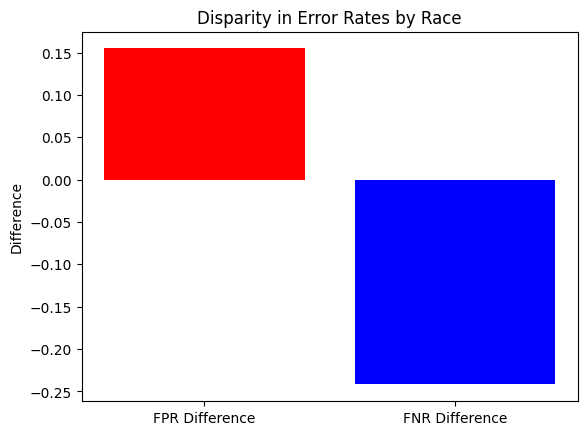

In [33]:
# 5. Visualization
fpr_diff = class_metric.false_positive_rate_difference()
fnr_diff = class_metric.false_negative_rate_difference()

plt.bar(['FPR Difference', 'FNR Difference'], [fpr_diff, fnr_diff], color=['red', 'blue'])
plt.title('Disparity in Error Rates by Race')
plt.ylabel('Difference')
plt.show()


In [34]:
# 6. Bias mitigation using Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

print("Reweighing completed. Weights applied to reduce bias.")

Reweighing completed. Weights applied to reduce bias.


In [35]:
# retrain classifier with reweighed dataset (weights stored in dataset_transf.instance_weights)
clf.fit(X_scaled, y, sample_weight=dataset_transf.instance_weights)
y_pred_reweighed = clf.predict(X_scaled)
dataset_pred_reweighed = dataset.copy()
dataset_pred_reweighed.labels = y_pred_reweighed


In [36]:
# New metrics after mitigation
class_metric_reweighed = ClassificationMetric(dataset,
                                              dataset_pred_reweighed,
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

print("Post-Reweighing FPR Difference:", class_metric_reweighed.false_positive_rate_difference())
print("Post-Reweighing FNR Difference:", class_metric_reweighed.false_negative_rate_difference())

Post-Reweighing FPR Difference: 0.1502209910678494
Post-Reweighing FNR Difference: -0.23629239971165272
